In [ ]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.2 MB/s eta 0:00:00


In [11]:
# LightGBM Model for House Price Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from scipy.stats import uniform, randint


In [2]:
# Load and prepare data
df = pd.read_csv('../Data/cleaned_train.csv')
df['SalePrice_Log'] = np.log(df['SalePrice'])



In [3]:
# Select features
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['SalePrice', 'SalePrice_Log'], axis=1).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])



In [4]:
# Split features and target
X = df.drop(['SalePrice', 'SalePrice_Log'], axis=1)
y = df['SalePrice_Log']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
# Build LightGBM pipeline
pipeline_LGBM = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42))
])

# Fit and predict
pipeline_LGBM.fit(X_train, y_train)
y_pred_log = pipeline_LGBM.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 196
[LightGBM] [Info] Start training from score 12.030652


In [6]:
# Evaluate
rmse = mean_squared_error(y_test_actual, y_pred, squared=False)
r2_train = pipeline_LGBM.score(X_train, y_train)
r2_test = r2_score(y_test_actual, y_pred)
print(f"LightGBM RMSE: {rmse:.2f}, R2 Train: {r2_train:.4f}, R2 Test: {r2_test:.4f}")



LightGBM RMSE: 28681.16, R2 Train: 0.9882, R2 Test: 0.8928


d:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
# Save model
joblib.dump(pipeline_LGBM, '../Results/GBM Result/lightgbm_regression_pipeline.joblib')

# Save predictions
output = pd.DataFrame({'Id': df['Id'] if 'Id' in df.columns else np.arange(1, len(df)+1), 'SalePrice': np.expm1(pipeline_LGBM.predict(X))})
output.to_csv('../Results/Train_predicted_saleprice_lightgbm.csv', index=False)
print('Predictions saved to ../Results/GBM Result/Train_predicted_saleprice_lightgbm.csv')



Predictions saved to ../Results/GBM Result/Train_predicted_saleprice_lightgbm.csv


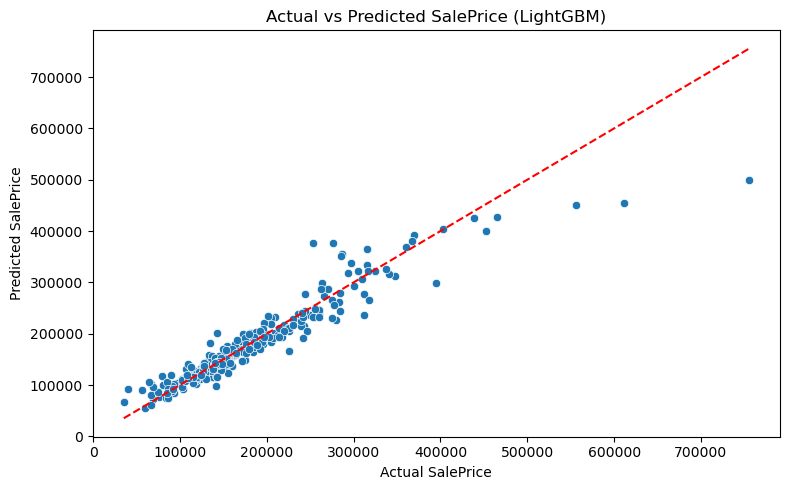

In [8]:
# Plot actual vs predicted
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_actual, y=y_pred)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (LightGBM)')
plt.tight_layout()
plt.savefig('../Results/GBM Result/actual_vs_predicted_lightgbm.png')
plt.show()

In [18]:
# Hyperparameter tuning for LightGBM
param_grid = {
    'regressor__num_leaves': [31, 63, 127],
    'regressor__max_depth': [5, 7, -1],
    'regressor__learning_rate': [0.01, 0.03, 0.05],
    'regressor__n_estimators': [300, 500, 800],
    'regressor__min_child_samples': [5, 10, 20],
    'regressor__min_split_gain': [0.0, 0.01],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 1.0]
}

from sklearn.model_selection import RandomizedSearchCV

random_search_lgbm = RandomizedSearchCV(
    pipeline_LGBM,
    param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search_lgbm.fit(X_train, y_train)

# Print best parameters & score
print('Best LightGBM parameters:', random_search_lgbm.best_params_)
print('Best CV RMSE:', -random_search_lgbm.best_score_)

# Predict and evaluate using the best estimator
y_pred_log_best = random_search_lgbm.best_estimator_.predict(X_test)
y_pred_best = np.expm1(y_pred_log_best)

rmse_best = mean_squared_error(y_test_actual, y_pred_best, squared=False)
r2_train_best = random_search_lgbm.best_estimator_.score(X_train, y_train)
r2_test_best = r2_score(y_test_actual, y_pred_best)

print(f"Test RMSE: {rmse_best:.2f}, R2 Train: {r2_train_best:.4f}, R2 Test: {r2_test_best:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 196
[LightGBM] [Info] Start training from score 12.030652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

d:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


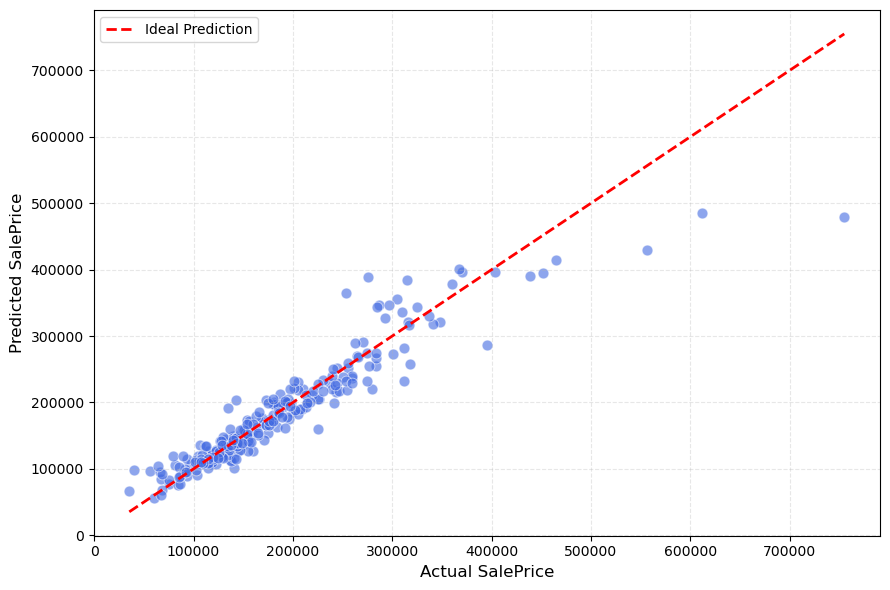

In [19]:
# Plot actual vs predicted
r2_score_value = r2_score(y_test_actual, y_pred_best)
plt.figure(figsize=(9,6))
sns.scatterplot(x=y_test_actual, y=y_pred_best, color='royalblue', alpha=0.6, s=60)
plt.plot(
    [y_test_actual.min(), y_test_actual.max()],
    [y_test_actual.min(), y_test_actual.max()],
    'r--', linewidth=2, label='Ideal Prediction'
)
plt.xlabel('Actual SalePrice', fontsize=12)
plt.ylabel('Predicted SalePrice', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('../Results/Tuned GBM/actual_vs_predicted_best_lightgbm.png', dpi=300)
plt.show()